In [43]:
import pandas as pd
import FinanceDataReader as fdr
from datetime import datetime
import numpy as np
import pandas_datareader as pdr

%matplotlib inline
import matplotlib.pyplot as plt

In [44]:
#ticker_list = ['305080.KS', 'IEF'] # TIGER 미국채10년선물 vs. IEF
# ticker_list = ['232080.KS', '280930.KS']
# ticker_list = ['143850.KS', '232080.KS']
ticker_list = ['143850.KS', '280930.KS']
start = datetime(2000, 1, 1)
end = datetime(2020, 12, 31)
init_balance = 1000

# 각 종목 별 수정 주가 데이터를 크롤링 해 리스트로 시계열 데이터 시리즈를 값으로 갖는 리스트 생성
#df_list = [fdr.DataReader(ticker, start, end)['Close'] for ticker in ticker_list]
df_list = [pdr.get_data_yahoo(ticker, start, end)['Adj Close'] for ticker in ticker_list]

df_price = pd.concat(df_list, axis=1) #주가 데이터 리스트를 데이터프레임으로 변환
df_price.columns = ticker_list
first_day = df_price.dropna().index.min() # 전 종목 결측치 없는 최초 일자를 거래시작일로 지정
df_new = df_price[first_day:].fillna(method='pad') # 최초일 이후의 결측치는 전일종가로 채움
last_day = df_new.index[-1] # 마지막 거래일 지정
time_period = ((last_day - first_day).days)/365 # 거래기간 계산 (년 기준)

df = df_new.copy()
for ticker in ticker_list: # 최초 거래일의 초기 잔고액 기준 일별 잔고 금액 계산
    df[ticker] = df[ticker] / float(df[ticker].head(1)) * init_balance

In [45]:
def performance_indicator(etf): # etf는 df["etf명"]
    date = etf.index.tolist()
    balance = etf.values.tolist()
    ###########최종 평가액, 첫거래일, 마지막거래일, 테스트기간###########
    final_balance = balance[-1]
    first_day, last_day = date[0], date[-1]
    time_period = ((last_day - first_day).days)/365
    
    CAGR = ((balance[-1]/balance[0]) ** (1 / float(time_period)) - 1) * 100
    cum_return = ((balance[-1]/balance[0] - 1) * 100)
    ###########신고가, MDD, 일 변동률###############################
    historic_high = 0
    historic_high_percent = 0
    MDD = 0
    drawdown_list = [0]
    daily_change_list = [0]
    
    for i in range(1, len(date)):     
        if historic_high < balance[i]:
            historic_high = balance[i] 

        drawdown_list.append((balance[i]/historic_high - 1) * 100)
        
        if MDD > drawdown_list[i]:
            MDD = drawdown_list[i]
        
        daily_change_list.append((balance[i]/balance[i-1] - 1)*100)
        
    historic_high_percent = (historic_high/balance[0] - 1)*100
    ###########STDEV, 샤프지수신고가################################
    # 일단위 변동성 연율화 하기 위해 252일 영업일 기준으로 루트 252 곱 함
    STDEV = np.std(daily_change_list) * np.sqrt(252) 
    sharpe_ratio = np.mean(daily_change_list) / np.std(daily_change_list) * np.sqrt(252) 
    
    my_str = []
    result_list = [init_balance, final_balance, CAGR, MDD, STDEV, sharpe_ratio]
    for my_number in result_list:
        if my_number in [CAGR, MDD]:
            my_str.append(str(round(my_number, 2))+' %')
        elif my_number in [final_balance]:
            my_str.append(str(round(my_number)))
        else : 
            my_str.append(str(round(my_number, 2)))
    
    first, last = first_day.strftime('%Y-%m-%d'), last_day.strftime('%Y-%m-%d')
    print(f'테스트기간 : {first} ~ {last} / {round(time_period,1)} 년')
    
    return my_str, drawdown_list

In [46]:
tmp = {
        'index': [],
        'data': [],
        'drawdown': []
    }
########### 포트폴리오 리턴 결과 표 ###############################
for ticker in ticker_list:
    tmp['index'].append(ticker)
    tmp['data'].append(performance_indicator(df[ticker])[0])
    tmp['drawdown'].append(performance_indicator(df[ticker])[1])

portfolio_return = pd.DataFrame(data=tmp['data'], index=tmp['index'], \
                   columns=['Init Balance', 'Final Balance', 'CAGR', 'MDD', 'STDEV', 'Sharpe Ratio'])

########### drawdown 리스트 -> 데이터프레임 변환 ###################
tmp_drawdown = [pd.DataFrame(data=tmp['drawdown'][i], index=df.index) for i in range(len(tmp['drawdown']))]
df_drawdown = pd.concat(tmp_drawdown, axis=1)
df_drawdown.columns=ticker_list

########### Annual Returns / Monthly Returns ###################
df['year'] = df.index.strftime('%Y')
df['year_month'] = df.index.strftime('%Y-%m')
annual = df.groupby('year').apply(lambda x: x.iloc[[-1]]).reset_index('Date').drop(['year_month', 'year', 'Date'], axis=1)
monthly = df.groupby('year_month').apply(lambda x: x.iloc[[-1]]).reset_index('Date').drop(['year_month', 'year', 'Date'], axis=1)

for ticker in ticker_list:
    for i in (range(len(annual)-1, 0, -1)):
        annual[ticker][i] = round((annual[ticker][i] / annual[ticker][i-1] - 1), 4) * 100
    for i in (range(len(monthly)-1, 0, -1)):
        monthly[ticker][i] = round((monthly[ticker][i] / monthly[ticker][i-1] - 1), 4) * 100
annual.iloc[0] = (annual.iloc[0] / init_balance - 1) * 100
monthly.iloc[0] = (monthly.iloc[0] / init_balance - 1) * 100

테스트기간 : 2017-11-07 ~ 2020-12-30 / 3.1 년
테스트기간 : 2017-11-07 ~ 2020-12-30 / 3.1 년
테스트기간 : 2017-11-07 ~ 2020-12-30 / 3.1 년
테스트기간 : 2017-11-07 ~ 2020-12-30 / 3.1 년


In [47]:
corr = df.corr(method = 'pearson')
corr

,143850.KS,280930.KS
143850.KS,1.000000,0.462706
280930.KS,0.462706,1.000000


In [48]:
portfolio_return

,Init Balance,Final Balance,CAGR,MDD,STDEV,Sharpe Ratio
143850.KS,1000,1411,11.57 %,-34.99 %,20.77,0.65
280930.KS,1000,1281,8.18 %,-45.12 %,26.24,0.44


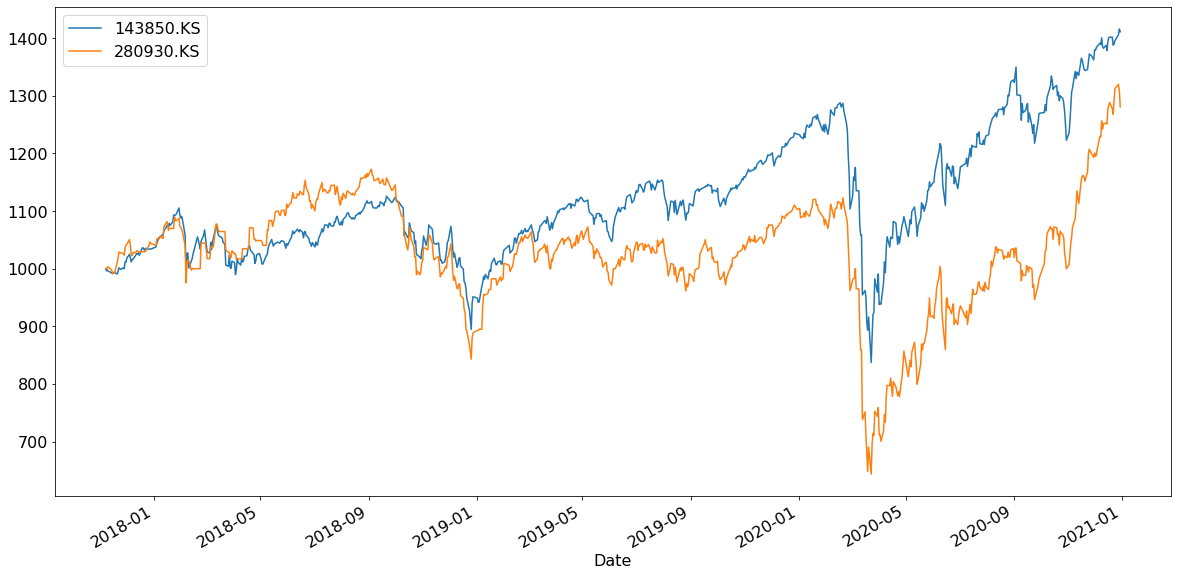

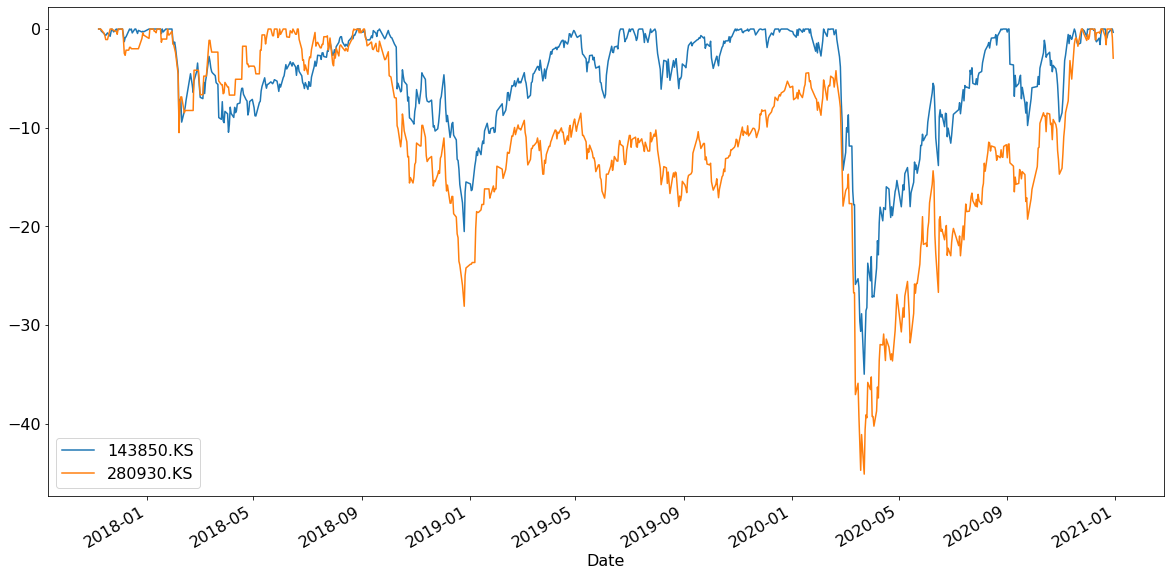

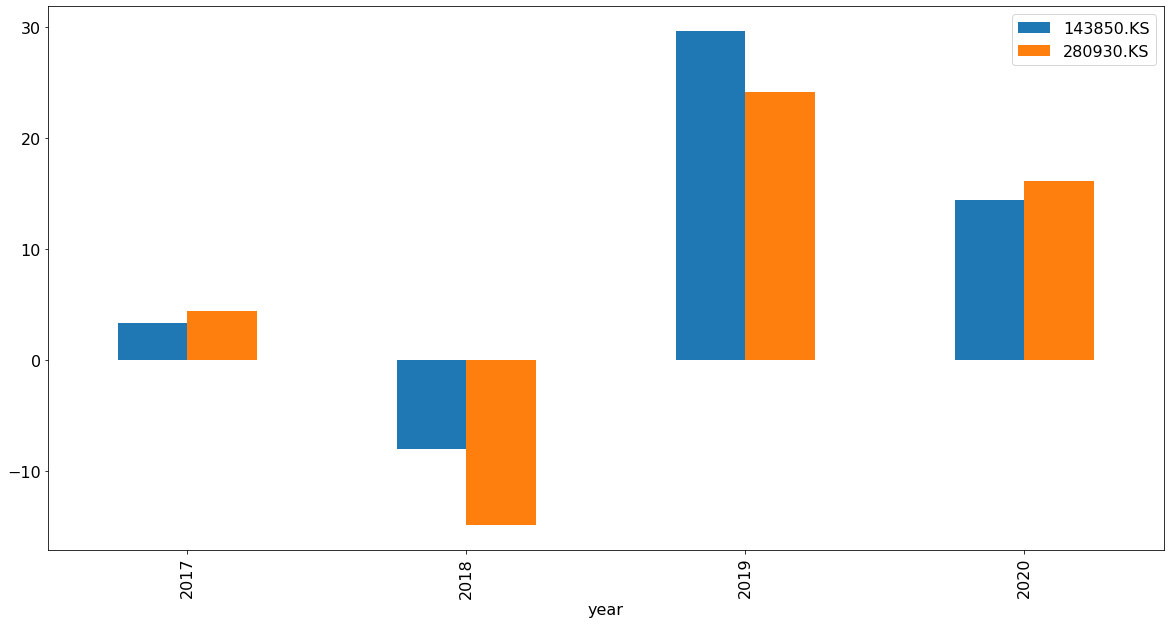

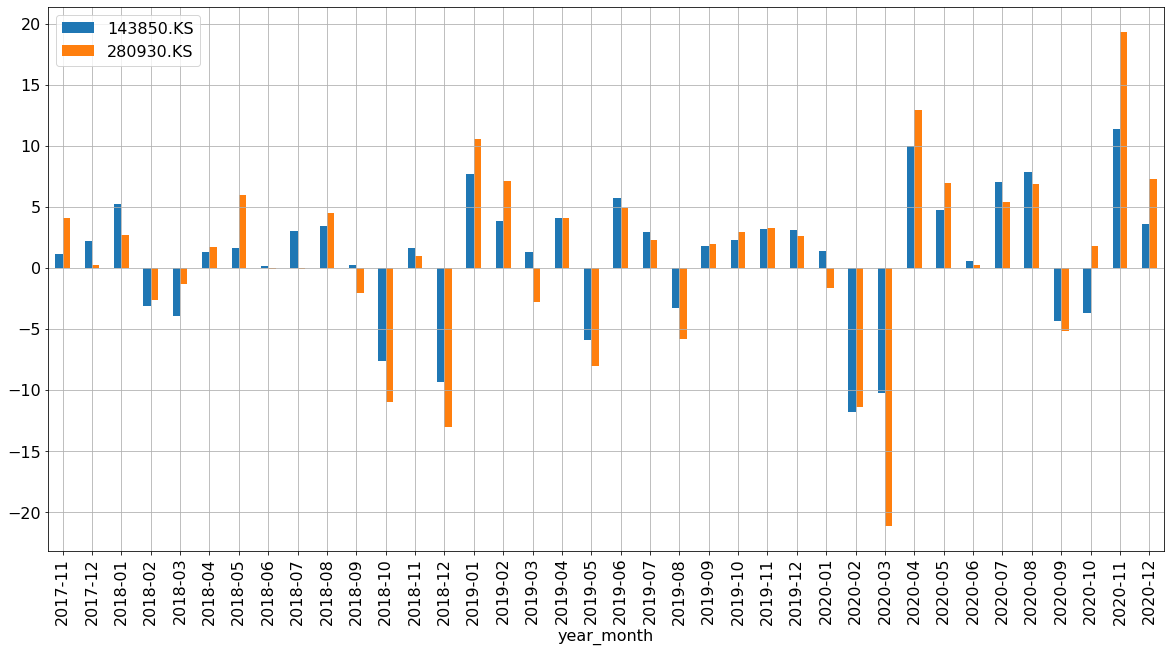

In [49]:
# 그래픽 크기 설정
plt.rcParams["font.size"] = 16
plt.rcParams["figure.figsize"] = (20, 10)

df.plot()
df_drawdown.plot()
annual.plot.bar()
monthly.plot.bar()
plt.grid()
plt.legend()
plt.show()